In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from dotenv import load_dotenv
import os
import re

# load the environment variables
load_dotenv()
PROJECT_PATH = os.getenv('PROJECT_PATH')

# set the path to music files
ROOT_PATH = f"{PROJECT_PATH}/genre-clustering/"
MUSIC_PATH = ROOT_PATH + "previews/"
SPECTOGRAM_PATH = ROOT_PATH + "spectograms/"

In [19]:
# convert previews into spectograms
filenames = os.listdir(MUSIC_PATH)
mel_filter = True

for filename in filenames:
    y, sr = librosa.load(MUSIC_PATH + filename)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    if mel_filter:
        D = librosa.feature.melspectrogram(S=D, sr=sr)
    np.save(SPECTOGRAM_PATH + filename + ".npy", D)

# prepare data
filenames = os.listdir(SPECTOGRAM_PATH)

data = [np.flip(np.load(SPECTOGRAM_PATH + filename)).flatten() for filename in filenames]
data[0].shape

(169344,)

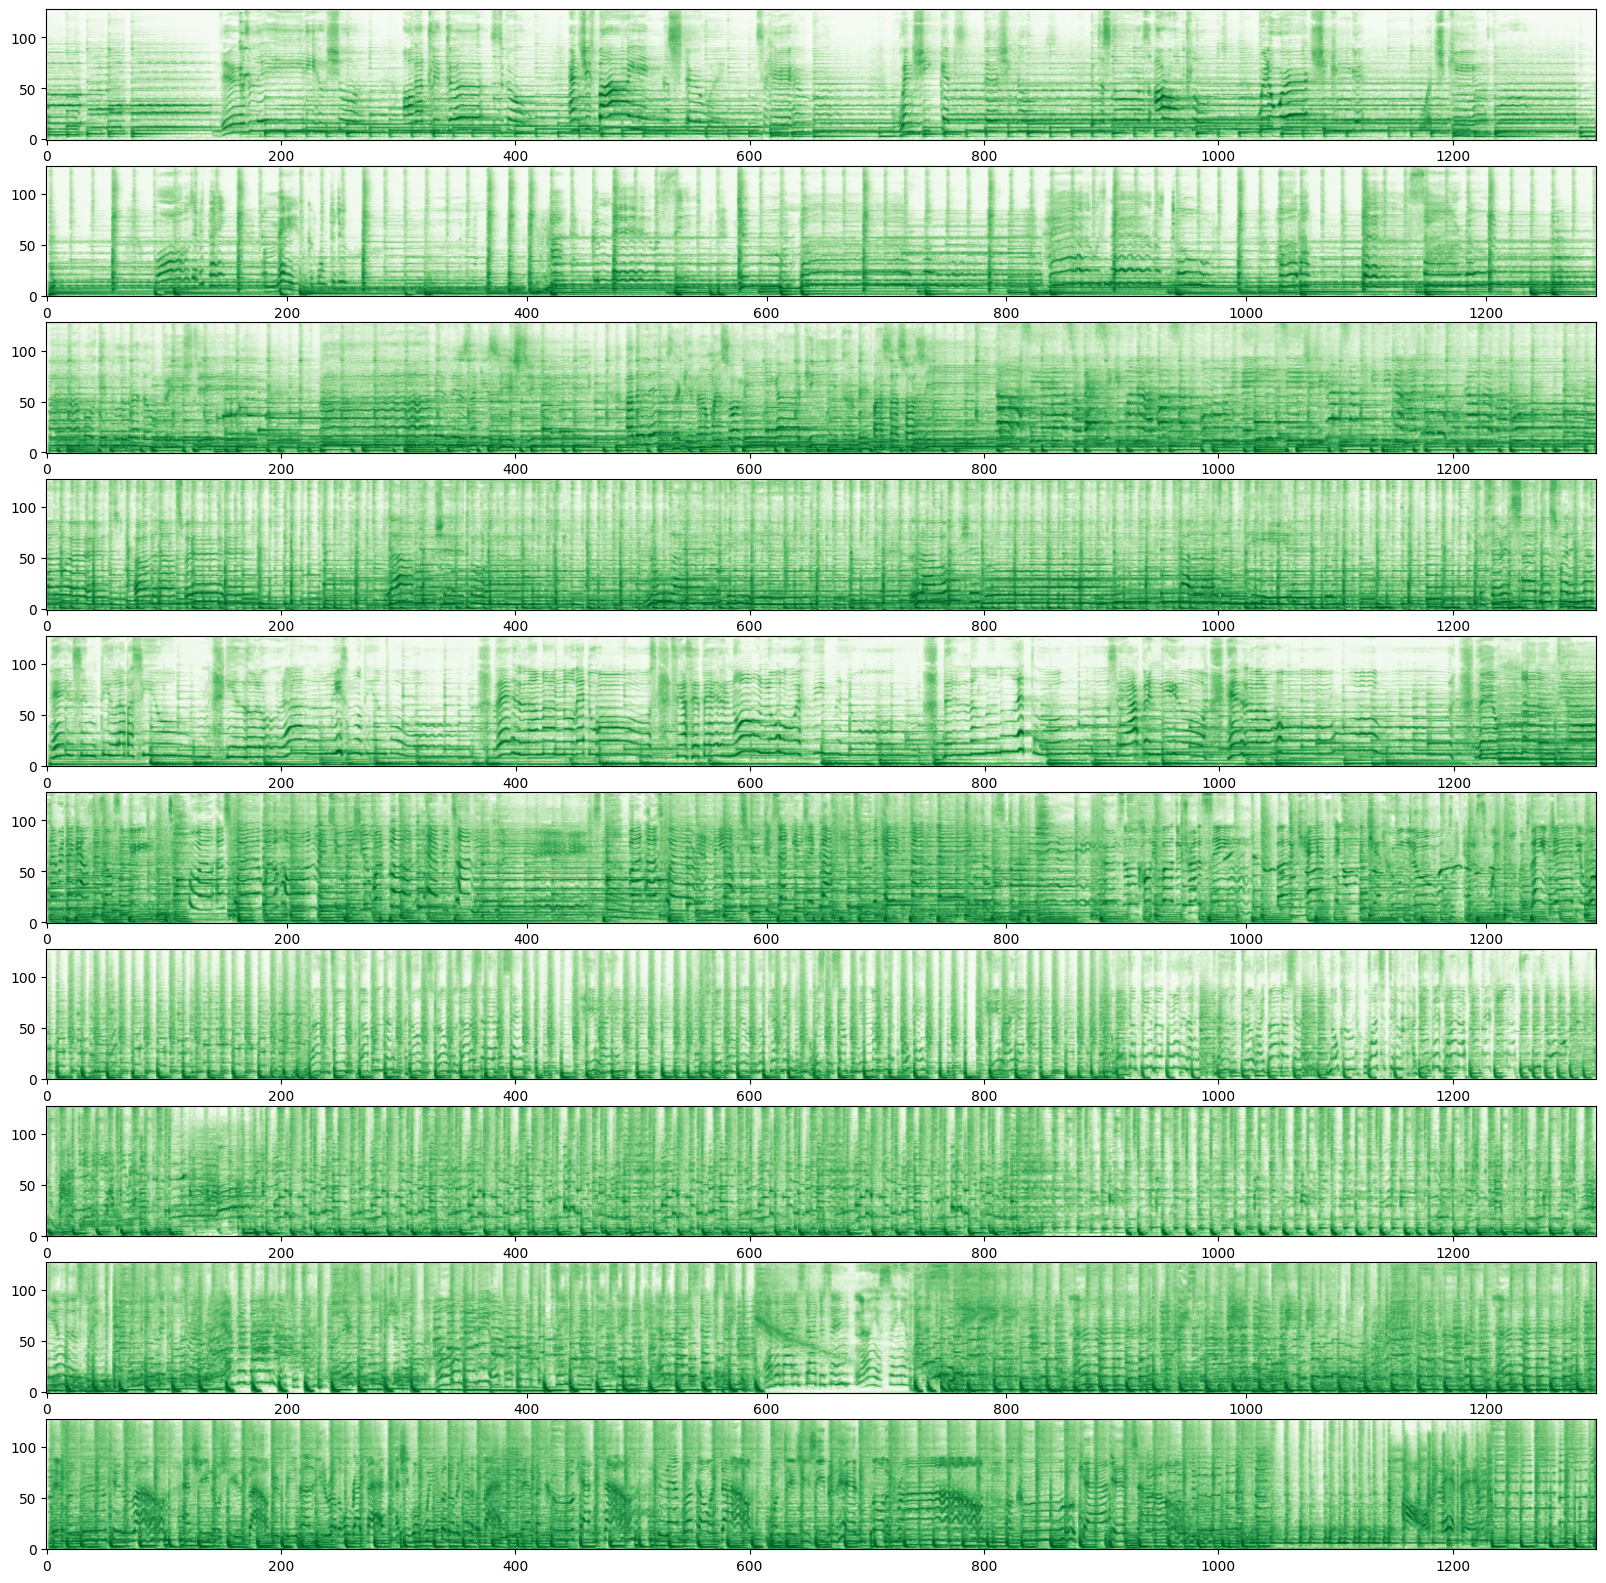

In [20]:
# plot spectograms
filenames = os.listdir(SPECTOGRAM_PATH) 
start, end = 10,20 
fig, ax = plt.subplots(len(filenames[start:end]), figsize=(20,20))
    
for idx, filename in enumerate(filenames[start:end]):
    D = np.load(SPECTOGRAM_PATH + filename)
    ax[idx].imshow(D, cmap='Greens', origin='lower', aspect='auto')

In [21]:
lengths = []
for spec in data:
    lengths.append(len(spec))
set(lengths)

{165376, 165504, 169216, 169344}

In [22]:
# bring all data on same size
data = np.array([data[i][0:np.min(lengths)] for i in range(len(data))], dtype=np.float64)

In [23]:
from sklearn.manifold import MDS

# fit MDS model data
mds = MDS(n_components=3, normalized_stress='auto')
data_reduced = mds.fit_transform(data)
#data_reduced

In [24]:
from sklearn.cluster import KMeans

# cluster the data
expected_cluster = 10
kmeans = KMeans(n_clusters=expected_cluster)
clusters = kmeans.fit_predict(data)
clusters

array([1, 9, 4, 6, 9, 6, 9, 6, 1, 1, 9, 9, 1, 1, 9, 3, 9, 5, 6, 6, 6, 6,
       6, 6, 5, 6, 1, 1, 6, 6, 6, 6, 6, 6, 1, 0, 6, 6, 7, 2, 6, 1, 1, 2,
       6, 9, 9, 4, 6, 1, 1, 9, 9, 5, 9, 2, 5, 5, 5, 8, 5, 4, 4, 5, 1, 1,
       5, 2, 9, 6, 9, 1, 1, 5, 4, 4, 1, 1, 7, 1, 2, 6, 9, 6])

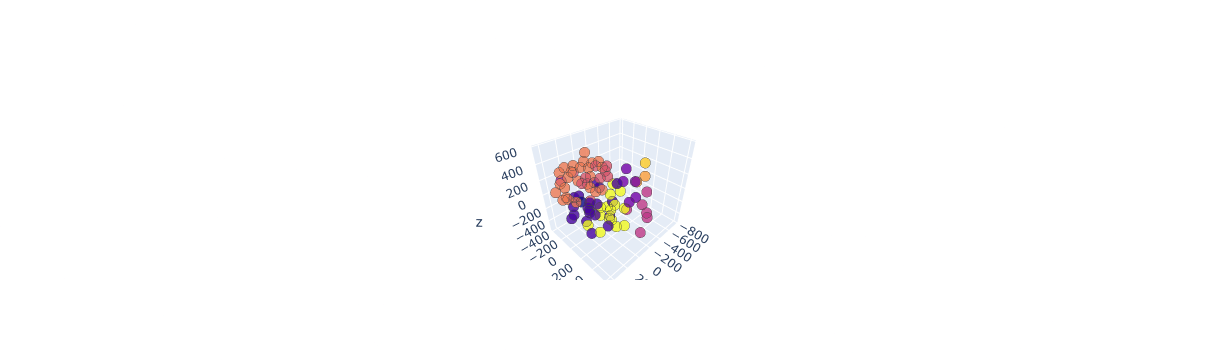

In [25]:
# plot the reduced data, color the cluster 
PLOT = go.Figure()
PLOT.add_trace(go.Scatter3d(x = data_reduced[:,0],
                            y = data_reduced[:,1],
                            z = data_reduced[:,2],    
                            text = clusters,
                            mode = 'markers',
                            hoverinfo="text",
                            marker=dict(
                                size=12,
                                color=clusters,  # set color to an array/list of desired values
                                opacity=0.8
                            ),
                            marker_size = 6,
                            marker_line_width = 1,
                           )
              )


In [26]:
# listen to specific music clusters

c = 2
cluster = np.array(filenames)[clusters == np.full((len(clusters)), c)]

links = [None] * len(cluster)
pattern = r".{13}_(\d+).mp3.npy"

for i in range(len(cluster)):
    match = re.search(pattern, cluster[i])
    if not match:
        print(cluster[i])
        continue
    links[i] = f"https://www.deezer.com/de/track/{match.groups(1)[0]}"

links

['https://www.deezer.com/de/track/1448879592',
 'https://www.deezer.com/de/track/1638506712',
 'https://www.deezer.com/de/track/1827107617',
 'https://www.deezer.com/de/track/1879412717',
 'https://www.deezer.com/de/track/1776184957']